In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

sadcp_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'u_sadcp', 'v_sadcp', 'lat_sadcp', 'lon_sadcp', 'z_sadcp', 'tim_sadcp'])

In [2]:
def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):

        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse
    

In [3]:
u, v, lat, lon, z, tim = sadcp_data['u_sadcp'], sadcp_data['v_sadcp'], sadcp_data['lat_sadcp'], sadcp_data['lon_sadcp'], sadcp_data['z_sadcp'], sadcp_data['tim_sadcp']
def julian_to_datetime(jd):
    # Julian date of the Unix epoch (Jan 1, 1970) is 2440587.5
    unix_time = (jd - 2440587.5) * 86400.0  # seconds since Unix epoch
    return datetime.datetime.utcfromtimestamp(unix_time)

tim_datetime = []
for t in tim:
    tim_datetime.append(julian_to_datetime(t))


In [4]:
def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

def moca(u1, v1, l):

    def find_root(x, y):
        coeffs = np.polyfit(x, y, 3)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid = x[len(x)//2]
        return real_roots[np.argmin(np.abs(mid - real_roots))]

    def tang_at_root(x, y, rx):
        coeffs = np.polyfit(x, y, 3)
        deriv = np.polyder(coeffs)
        slope = np.polyval(deriv, rx)
        intercept = np.polyval(coeffs, rx) - slope * rx
        return slope, intercept
    
    def cubic_interpolate(x, y, root):
        coeffs = np.polyfit(x, y, 3)
        return np.polyval(coeffs, root)

    root = find_root(l, v1)
    c, b = tang_at_root(l, v1, root)  # c: slope, b: intercept
    a = cubic_interpolate(l, u1, root)
    
    x0 = -b / c
    y0 = a / c
    w = 2 * c
    
    return x0, y0, w 

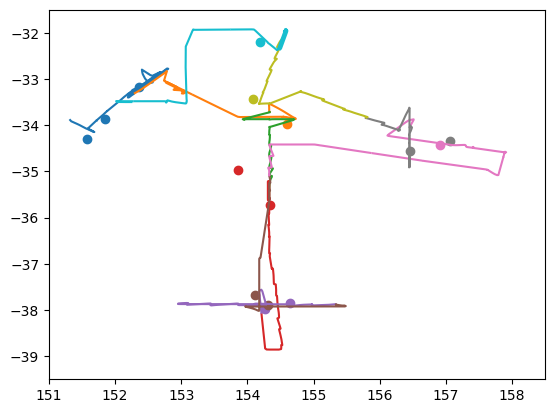

In [5]:
u_data = pd.DataFrame(u, columns=tim_datetime, index=z)
v_data = pd.DataFrame(v, columns=tim_datetime, index=z)

depth = 37
ship_data = pd.DataFrame({'Time': tim_datetime, 'Lon': lon, 'Lat': lat, 'u': u_data.loc[depth], 'v': v_data.loc[depth]}).dropna()
ship_data = ship_data.set_index('Time')

unique_days = sorted(set(ship_data.index.date))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_days)))
for day, color in zip(unique_days, colors):
    day_data = ship_data[ship_data.index.date == day]
    plt.plot(day_data['Lon'], day_data['Lat'], color=color, label=str(day))

    xi, yi, ui, vi = day_data['Lon'], day_data['Lat'], day_data['u'], day_data['v']
    x0, y0, Q, w = espra(xi, yi, ui, vi)
    
    plt.scatter(x0, y0, color=color)

plt.xlim(151, 158.5)
plt.ylim(-39.5, -31.5)
# plt.legend(title='Day')
plt.show()

In [6]:
# # Assuming ship_data is already defined with a datetime index
# # Create a new column that floors the time to the nearest 6-hour period
# ship_data['6h'] = ship_data.index.floor('6h')

# # Get the unique 6-hour periods in sorted order
# unique_periods = sorted(ship_data['6h'].unique())

# # Create a color map with a distinct color for each period
# colors = plt.cm.tab10(np.linspace(0, 1, len(unique_periods)))

# # Loop over each 6-hour period, plot the segment and associated scatter points
# for period, color in zip(unique_periods, colors):
#     period_data = ship_data[ship_data['6h'] == period]
#     plt.plot(period_data['Lon'], period_data['Lat'], color=color, label=str(period))
    
#     # Extract the data for the espra function (assuming espra is defined)
#     xi, yi, ui, vi = period_data['Lon'], period_data['Lat'], period_data['u'], period_data['v']
#     x0, y0, q11, q12, q22, w = espra(xi, yi, ui, vi)
#     plt.scatter(x0, y0, color=color)

# plt.xlim(151, 158.5)
# plt.ylim(-39.5, -31.5)
# plt.show()


In [7]:
import glob
import netCDF4 as nc
from netCDF4 import Dataset, num2date

def convert_to_datetime(time_val, time_variable):
    dt = num2date(time_val, units=time_variable.units,
                  calendar=getattr(time_variable, 'calendar', 'gregorian'))
    try:
        return [d.to_pydatetime() if hasattr(d, 'to_pydatetime') else d for d in dt]
    except TypeError:
        return dt.to_pydatetime() if hasattr(dt, 'to_pydatetime') else dt

nc_files = glob.glob('/srv/scratch/z5297792/IN2023/marina_observational_data/IN23_SSH/*.nc')

time_ssh = []
filenames = []
df_ssh_times = pd.DataFrame(columns=['Time', 'fname'])
for filename in nc_files:
    with nc.Dataset(filename, mode='r') as ssh_data:
        # Convert the first time value in the TIME variable
        dt = convert_to_datetime(ssh_data['TIME'][:], ssh_data.variables['TIME'])[0]
        df_ssh_times.loc[len(df_ssh_times)] = {'Time': dt, 'fname': filename}
df_ssh_times = df_ssh_times.sort_values(by='Time').reset_index(drop=True)
df_ssh_times = df_ssh_times.set_index('Time')

df_ssh_times


,fname
Time,
2023-10-06 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-07 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-08 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-09 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-10 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-11 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-12 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-13 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-14 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...


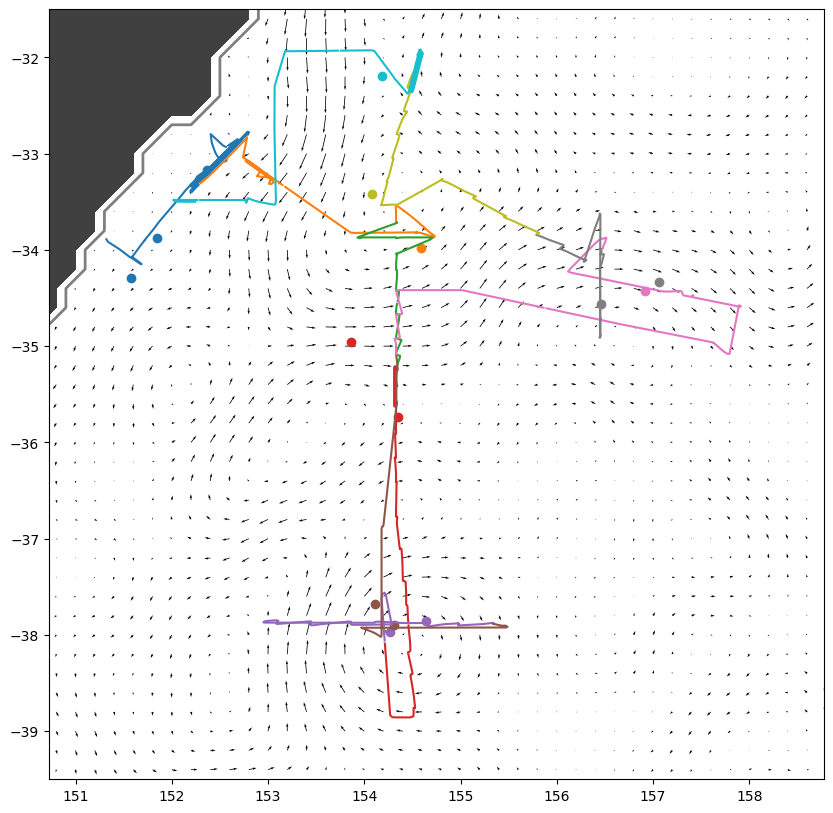

In [8]:
ssh_data = nc.Dataset(df_ssh_times.iloc[0]['fname'], mode='r')

LON, LAT = ssh_data['LONGITUDE'][:].data.squeeze(), ssh_data['LATITUDE'][:].data.squeeze()
LON, LAT = np.meshgrid(LON, LAT)
ucur, vcur = ssh_data['UCUR'][:].data.squeeze(), ssh_data['VCUR'][:].data.squeeze()
ucur, vcur = np.where(np.abs(ucur) > 100, np.nan, ucur), np.where(np.abs(vcur) > 100, np.nan, vcur)

plt.figure(figsize=(10,10))

spacing = 1
plt.quiver(LON[::spacing, ::spacing], LAT[::spacing, ::spacing], ucur[::spacing, ::spacing], vcur[::spacing, ::spacing], scale=50, width=.001)

unique_days = sorted(set(ship_data.index.date))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_days)))
for day, color in zip(unique_days, colors):
    day_data = ship_data[ship_data.index.date == day]
    plt.plot(day_data['Lon'], day_data['Lat'], color=color, label=str(day))

    xi, yi, ui, vi = day_data['Lon'], day_data['Lat'], day_data['u'], day_data['v']
    x0, y0, Q, w = espra(xi, yi, ui, vi)
    
    plt.scatter(x0, y0, color=color)
    
mask = (LON > 148) & (LON < 160) & (LAT > -42) & (LAT < -28)
ucur = np.where(mask, ucur, 0)
if np.any(np.isnan(ucur)):
    nan_mask = np.isnan(ucur)
    mask = np.where(~np.isnan(ucur), np.nan, 0)
    plt.contourf(LON, LAT, mask, cmap='gray', zorder=-1)
    plt.contour(LON, LAT, nan_mask, colors='k', linewidths=2, alpha=.5)

plt.axis('equal')
plt.xlim(151, 158.5)
plt.ylim(-39.5, -31.5)
plt.show()

In [9]:
# Interested in CE south of -36
CE_ship_data = ship_data[ship_data['Lat'] < -36]
CE_ship_data['D'] = CE_ship_data.index.floor('D')
CE_unique_days = sorted(set(CE_ship_data.index.date)) # The days we sail over the CE
# Get SSH data during our sail over the CE
CE_unique_days_set = set(CE_unique_days)
mask = [datetime.date(t.year, t.month, t.day) in CE_unique_days_set for t in df_ssh_times.index]
CE_filtered_df = df_ssh_times[mask]
CE_filtered_df.index = CE_filtered_df.index.round('D')
CE_filtered_df

/scratch/pbs.6336053.kman.restech.unsw.edu.au/ipykernel_1438975/1386211852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CE_ship_data['D'] = CE_ship_data.index.floor('D')


,fname
Time,
2023-10-16 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-17 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-18 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-19 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-20 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-21 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-22 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...


In [10]:
CE_ship_data

,Lon,Lat,u,v,D
Time,,,,,
2023-10-16 17:12:30.333340,154.323370,-36.001695,-0.327103,0.220104,2023-10-16
2023-10-16 17:27:30.999990,154.324502,-36.032252,-0.373298,0.221278,2023-10-16
2023-10-16 17:42:30.666685,154.325731,-36.060667,-0.375881,0.241360,2023-10-16
2023-10-16 17:57:30.333340,154.326806,-36.087062,-0.398380,0.286181,2023-10-16
2023-10-16 18:12:30.666659,154.327959,-36.113159,-0.415123,0.286487,2023-10-16
...,...,...,...,...,...
2023-10-22 04:57:30.666685,154.274131,-36.170273,-0.160337,0.042481,2023-10-22
2023-10-22 05:12:30.333340,154.278650,-36.128659,-0.213869,-0.012548,2023-10-22
2023-10-22 05:27:30.666659,154.283247,-36.086704,-0.209879,-0.081813,2023-10-22


/scratch/pbs.6336053.kman.restech.unsw.edu.au/ipykernel_1438975/333960994.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x0_moca, y0_moca, w_moca = moca(ui, vi, xi-xi[0])
/scratch/pbs.6336053.kman.restech.unsw.edu.au/ipykernel_1438975/2824028444.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mid = x[len(x)//2]


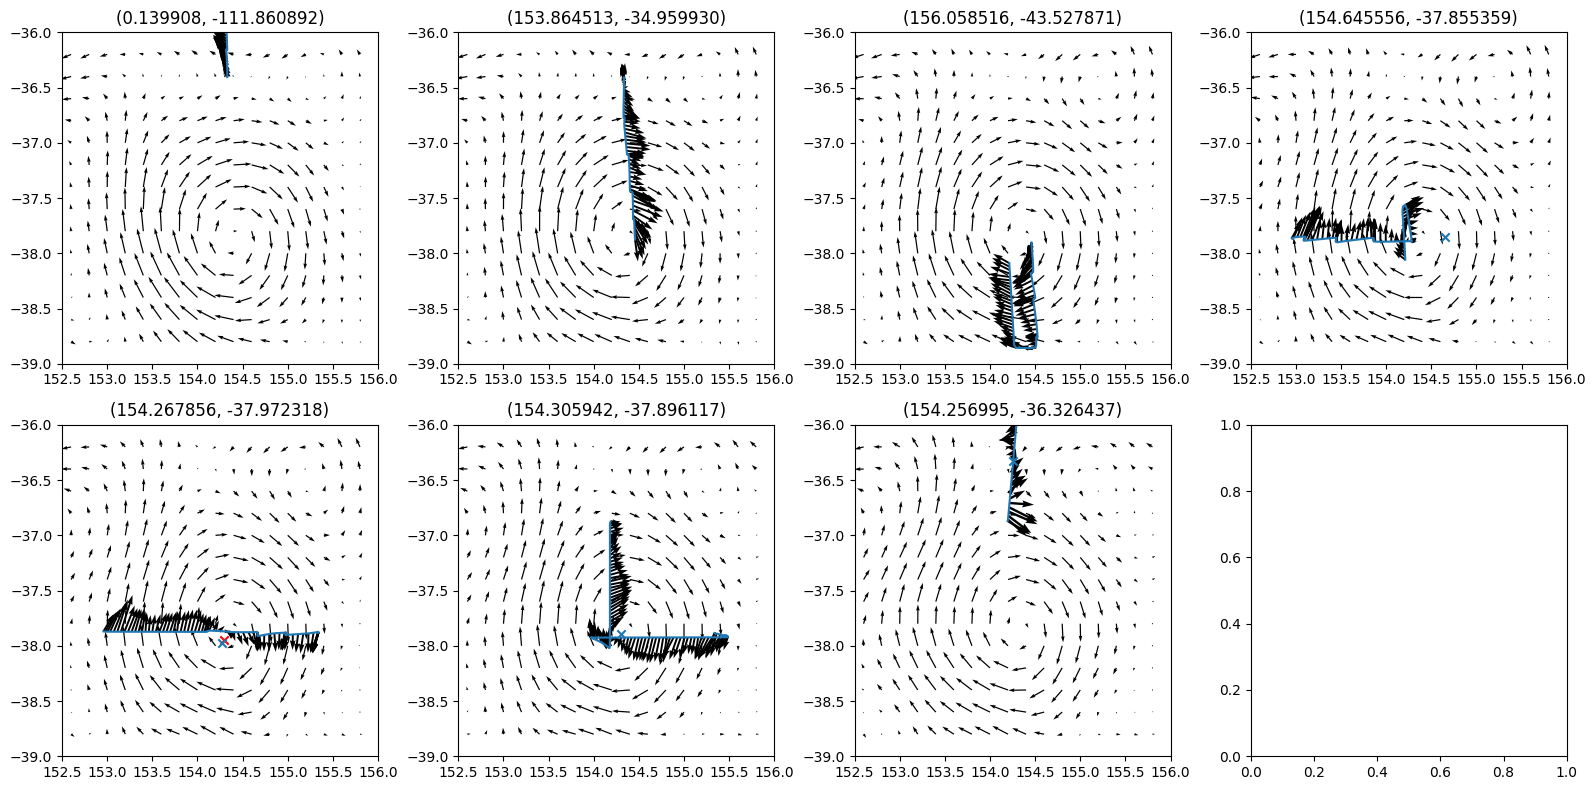

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

xmin, xmax = 152.5, 156
ymin, ymax = -39, -36

for d, day in enumerate(CE_unique_days):
    ax = axs[d // 4, d % 4]

    # PLOT SSH DATA
    with nc.Dataset(CE_filtered_df.iloc[d]['fname'], mode='r') as ds:
        lon = ds['LONGITUDE'][:].squeeze()
        lat = ds['LATITUDE'][:].squeeze()
        lon, lat = np.meshgrid(lon, lat)
        u = ds['UCUR'][:].squeeze()
        v = ds['VCUR'][:].squeeze()
    u = np.where(np.abs(u) > 100, np.nan, u)
    v = np.where(np.abs(v) > 100, np.nan, v)
    mask = (lon > xmin) & (lon < xmax) & (lat > ymin) & (lat < ymax)
    idx = np.where(mask)
    spacing = 1
    ax.quiver(lon[idx][::spacing], lat[idx][::spacing], u[idx][::spacing], v[idx][::spacing], scale=None, width=None)

    # PLOT RV DATA
    day = pd.Timestamp(day)
    day_data = CE_ship_data[day==CE_ship_data['D']]

    xi, yi, ui, vi = day_data['Lon'], day_data['Lat'], day_data['u'], day_data['v']
    x0, y0, Q, w = espra(xi, yi, ui, vi)

    if d == 4:
        x0_moca, y0_moca, w_moca = moca(ui, vi, xi-xi[0])
    
        x0_moca += xi.iloc[0] 
        y0_moca += yi.iloc[0]

        ax.scatter(x0_moca, y0_moca, marker='x', color='r')

    ax.plot(xi, yi)
    ax.quiver(xi, yi, ui, vi)
    
    ax.scatter(x0, y0, marker='x')
    ax.set_title(f'({x0:02f}, {y0:02f})')

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## MOCA

/scratch/pbs.6336053.kman.restech.unsw.edu.au/ipykernel_1438975/2007115066.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x0, y0, w = moca(ui, vi, xi-xi[0])
/scratch/pbs.6336053.kman.restech.unsw.edu.au/ipykernel_1438975/2824028444.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mid = x[len(x)//2]
/scratch/pbs.6336053.kman.restech.unsw.edu.au/ipykernel_1438975/2007115066.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


(-39.0, -36.0)

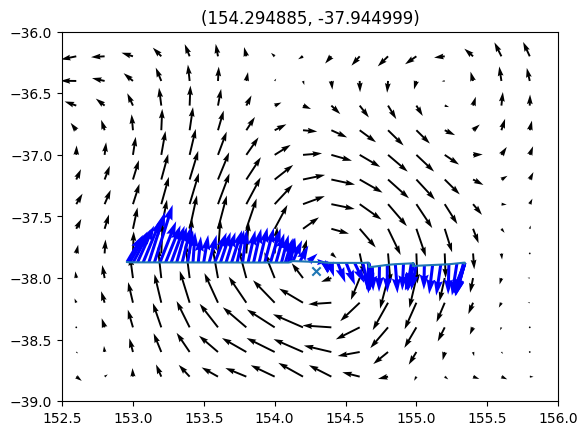

In [12]:
# PLOT SSH DATA
with nc.Dataset(CE_filtered_df.iloc[4]['fname'], mode='r') as ds:
    lon = ds['LONGITUDE'][:].squeeze()
    lat = ds['LATITUDE'][:].squeeze()
    lon, lat = np.meshgrid(lon, lat)
    u = ds['UCUR'][:].squeeze()
    v = ds['VCUR'][:].squeeze()
u = np.where(np.abs(u) > 100, np.nan, u)
v = np.where(np.abs(v) > 100, np.nan, v)
mask = (lon > xmin) & (lon < xmax) & (lat > ymin) & (lat < ymax)
idx = np.where(mask)
spacing = 1
plt.quiver(lon[idx][::spacing], lat[idx][::spacing], u[idx][::spacing], v[idx][::spacing], scale=None, width=None)

# PLOT RV DATA
day = pd.Timestamp(CE_unique_days[4])
day_data = CE_ship_data[day==CE_ship_data['D']]

xi, yi, ui, vi = day_data['Lon'], day_data['Lat'], day_data['u'], day_data['v']
x0, y0, w = moca(ui, vi, xi-xi[0])

x0 += xi[0] 
y0 += yi[0]

plt.plot(xi, yi)
plt.quiver(xi, yi, ui, vi, color='b')

plt.scatter(x0, y0, marker='x')
plt.title(f'({x0:02f}, {y0:02f})')

# plt.plot(lon_drifter, lat_drifter)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


In [13]:
def straighten(x, y, u, v, n=None):
    from scipy.interpolate import interp1d
    x, y, u, v = np.asarray(x), np.asarray(y), np.asarray(u), np.asarray(v)
    n = n or len(x)
    m, b = np.polyfit(x, y, 1)
    pts = np.column_stack((x, y))
    vec = np.array([1, m])
    vec /= np.linalg.norm(vec)
    ref = pts[0]
    d = np.dot(pts - ref, vec)
    d_uniform = np.linspace(d.min(), d.max(), n)
    u_new = interp1d(d, u, kind='linear')(d_uniform)
    v_new = interp1d(d, v, kind='linear')(d_uniform)
    pts_new = ref + np.outer(d_uniform, vec)
    ut_new = u_new * vec[0] + v_new * vec[1]
    norm = np.array([-vec[1], vec[0]])
    un_new = u_new * norm[0] + v_new * norm[1]
    return pts_new[:, 0], pts_new[:, 1], u_new, v_new, ut_new, un_new


In [14]:
CE_filtered_df

,fname
Time,
2023-10-16 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-17 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-18 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-19 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-20 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-21 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-22 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...


-1.8979277992094554
-5.826915937270995
-0.23646660626104898
-3.295808036970644
-5.489013607645488
-0.5363905639098754


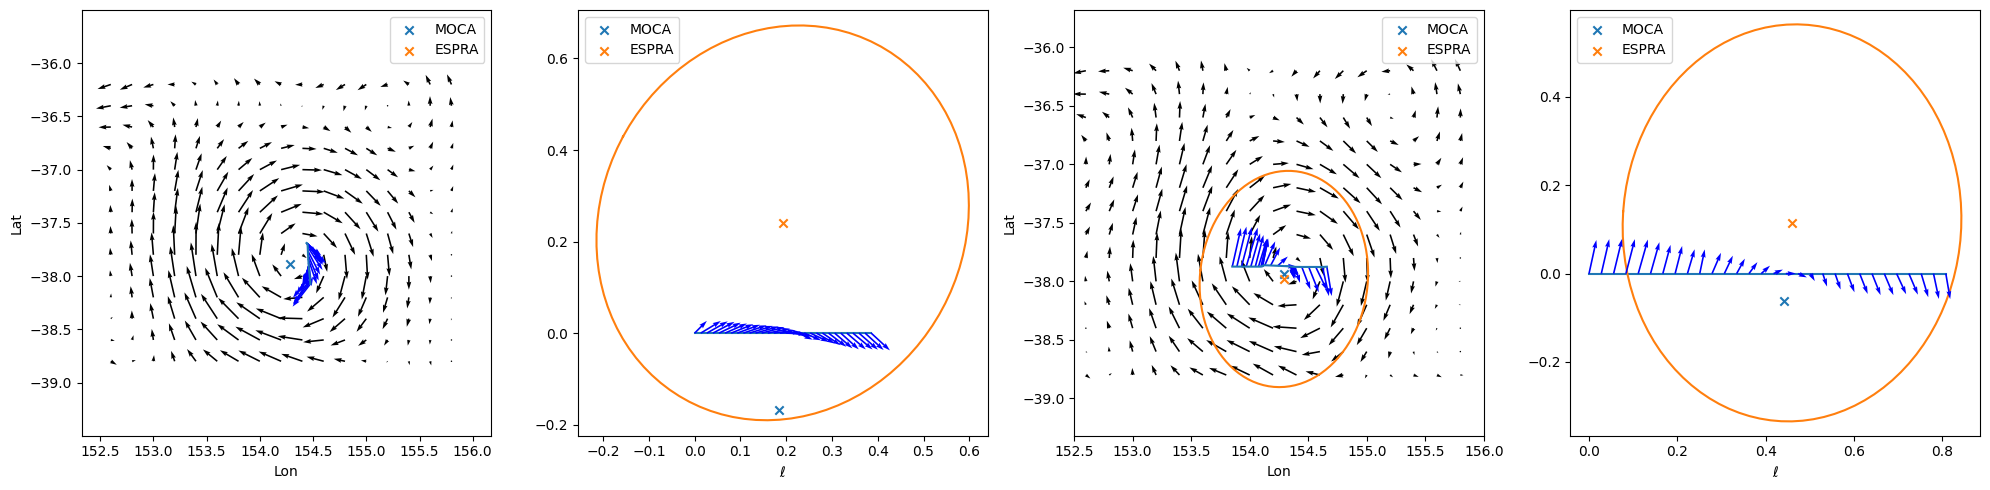

In [39]:
def find_closest_date(cftime_dates, target):
    if not isinstance(target, pd.Timestamp):
        target = pd.Timestamp(target)
    ts_dates = [pd.Timestamp(d.isoformat()) for d in cftime_dates]
    return min(ts_dates, key=lambda d: abs(d - target))

def compute_v_unit(x, y):
    dx = x[-1] - x[0]
    dy = y[-1] - y[0]
    norm = np.sqrt(dx**2 + dy**2)
    return np.array([dx / norm, dy / norm])
    
def find_point(ref, v_unit, d_along, d_perp):
    return ref + d_along * v_unit + d_perp * np.array([-v_unit[1], v_unit[0]])

# Define plot limits and time indices
xmin, xmax = 152.5, 156
ymin, ymax = -39, -36
width = 0.004

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for e, (t1, t2) in enumerate([(60, 180), (300, 420)]):
for e, (t1, t2) in enumerate([(110, 140), (340, 370)]):

    t_mean = CE_ship_data.iloc[t1:t2].index.mean()
    
    # Retrieve the closest date and corresponding filename
    closest_date = find_closest_date(np.array(CE_filtered_df.index), t_mean)
    fname = CE_filtered_df.loc[closest_date]['fname']
    
    # Plot SSH Data
    with nc.Dataset(fname, mode='r') as ds:
        lon = ds['LONGITUDE'][:].squeeze()
        lat = ds['LATITUDE'][:].squeeze()
        lon, lat = np.meshgrid(lon, lat)
        u = ds['UCUR'][:].squeeze()
        v = ds['VCUR'][:].squeeze()
    
    u = np.where(np.abs(u) > 100, np.nan, u)
    v = np.where(np.abs(v) > 100, np.nan, v)
    
    mask = (lon > xmin) & (lon < xmax) & (lat > ymin) & (lat < ymax)
    idx = np.where(mask)
    
    spacing = 1
    axs[0+2*e].quiver(
        lon[idx][::spacing], lat[idx][::spacing],
        u[idx][::spacing], v[idx][::spacing],
        scale=None, width=None
    )
    
    # Plot RV Data
    day_data = CE_ship_data.iloc[t1:t2]
    xi = np.array(day_data['Lon'])
    yi = np.array(day_data['Lat'])
    ui = np.array(day_data['u'])
    vi = np.array(day_data['v'])

    # plot 1
    x0_espra, y0_espra, Q_espra, w_espra = espra(xi, yi, ui, vi)
    axs[0+2*e].plot(xi, yi)
    axs[0+2*e].quiver(xi, yi, ui, vi, color='b',width=width)
    xi, yi, ui, vi, V_T, V_N = straighten(xi, yi, ui, vi)
    print(w_espra)
    l = np.hypot(xi - xi[0], yi - yi[0])

    x0l, y0l, w = moca(V_T, V_N, l)
    print(w)

    v_unit = compute_v_unit(xi, yi)
    ref = np.array([xi[0], yi[0]])
    x0, y0 = find_point(ref, v_unit, x0l, y0l)

    axs[0+2*e].scatter(x0, y0, marker='x', label='MOCA', zorder=5)
    axs[0+2*e].scatter(x0_espra, y0_espra, marker='x', label='ESPRA', zorder=5)
    x_ell, y_ell = plot_ellipse(Q_espra, (x0_espra, y0_espra))
    axs[0+2*e].plot(x_ell, y_ell)
    
    axs[0+2*e].legend()
    axs[0+2*e].axis('equal')
    axs[0+2*e].set_xlim(xmin, xmax)
    axs[0+2*e].set_ylim(ymin, ymax)
    axs[0+2*e].set_xlabel('Lon')
    axs[0+2*e].set_ylabel('Lat')
    
    # plot 2
    
    axs[1+2*e].plot(l, np.zeros_like(l))
    axs[1+2*e].quiver(l, np.zeros_like(l), V_T, V_N, color='b', zorder=3, width=width)
    axs[1+2*e].scatter(x0l, y0l, marker='x', label='MOCA')
    x0_espral, y0_espral, Q_espral, w_espral = espra(l, [0]*len(l), V_T, V_N)
    print(w_espral)
    x_ell, y_ell = plot_ellipse(Q_espral, (x0_espral, y0_espral), scale=.5)
    axs[1+2*e].plot(x_ell, y_ell)
    axs[1+2*e].scatter(x0_espral, y0_espral, marker='x',  label='ESPRA')
    
    axs[1+2*e].legend()
    axs[1+2*e].set_xlabel(r'$\ell$')
    axs[1+2*e].axis('equal')

plt.tight_layout()
plt.show()


MOCA producing reasonable results, ESPRA however clearly struggles using linear data. 

## Drifers

In [16]:
from datetime import datetime

drifter_path = '/srv/scratch/z5297792/IN2023/2023_CCE_drifters.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')
u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
tim_drif = drifter_dataset['time'][:].data

xmin, xmax = 151, 156
ymin, ymax = -39, -36

mask = (lon_drif >= xmin) & (lon_drif <= xmax) & (lat_drif >= ymin) & (lat_drif <= ymax)
u_drif, v_drif, lon_drif, lat_drif, tim_drif = u_drif[mask], v_drif[mask], lon_drif[mask], lat_drif[mask], tim_drif[mask]
dt_strings = [b''.join(row).decode('utf-8') for row in tim_drif]
dt_objects = [datetime.fromisoformat(s) for s in dt_strings]

df_drif = pd.DataFrame({'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': dt_objects}).dropna()

spike_indices = np.where(np.hypot(df_drif['Lon'].diff(), df_drif['Lat'].diff()) > .5)[0]

df_drif1 = df_drif[:spike_indices[0]]
df_drif2 = df_drif[spike_indices[0]:spike_indices[1]]
df_drif3 = df_drif[spike_indices[1]:spike_indices[2]]
df_drif4 = df_drif[spike_indices[2]:spike_indices[3]]
df_drif5 = df_drif[spike_indices[3]:]

def find_spike_indices(dt_list):
    spike_indices = []
    # Start from index 1 since there's no previous value for index 0
    for i in range(1, len(dt_list)):
        if dt_list[i] < dt_list[i - 1]:
            spike_indices.append(i)
    return spike_indices

drift1 = df_drif2

spike_indices = find_spike_indices(np.array(df_drif3['Time']))
drift2 = df_drif3.iloc[spike_indices[0]:]

spike_indices = find_spike_indices(np.array(df_drif5['Time']))
drift3 = df_drif5.iloc[spike_indices[0]:]


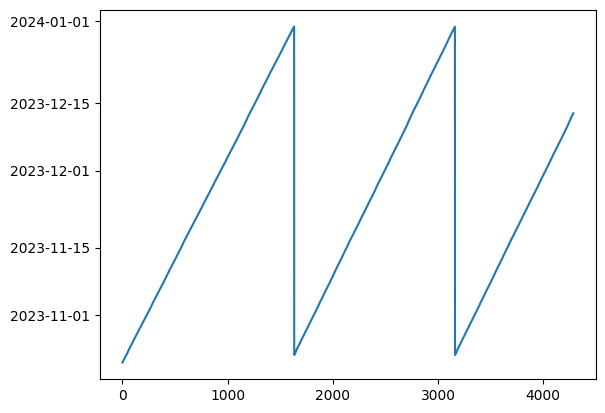

In [152]:
plt.plot(df_drif['Time'])

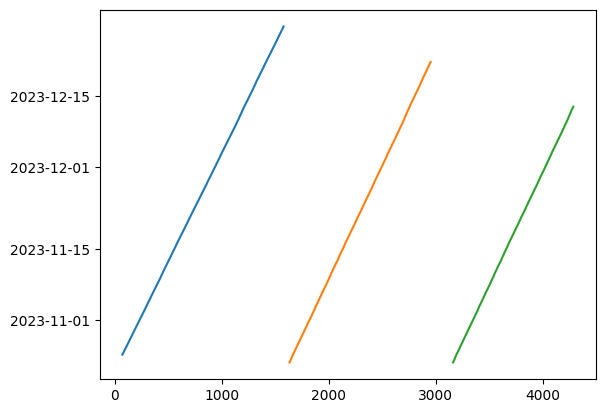

In [45]:
plt.plot(drift1['Time'])
plt.plot(drift2['Time'])
plt.plot(drift3['Time'])

In [115]:
df_drif

,Lon,Lat,u,v,Time
0,152.752487,-37.422474,-0.287410,-0.125541,2023-10-22 02:42:00
1,152.743805,-37.428650,-0.625086,-0.268273,2023-10-22 03:42:00
2,152.733505,-37.442516,-0.629687,-0.266857,2023-10-22 04:00:00
3,152.722229,-37.457474,-0.279366,-0.116640,2023-10-22 05:00:00
4,152.714508,-37.471188,-0.222752,-0.064746,2023-10-22 06:00:00
...,...,...,...,...,...
4281,152.583237,-37.210903,-0.261002,-0.154695,2023-12-12 18:00:00
4282,152.567017,-37.222069,-0.300502,-0.209841,2023-12-12 19:00:00
4283,152.552780,-37.233448,-0.307547,-0.251971,2023-12-12 20:00:00
4284,152.538651,-37.245686,-0.295753,-0.309900,2023-12-12 21:00:00


-0.08032841828375362
0.4277968157518469
1.11459648468597


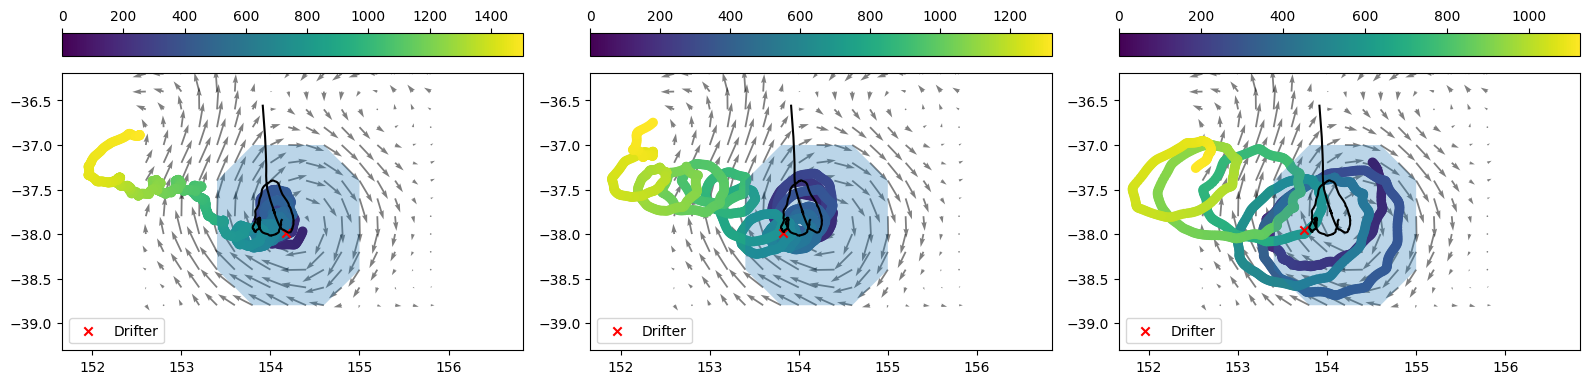

In [167]:
from scipy.spatial import ConvexHull

with nc.Dataset(CE_filtered_df.iloc[-1]['fname'], mode='r') as ds:
    lon = ds['LONGITUDE'][:].squeeze()
    lat = ds['LATITUDE'][:].squeeze()
    lon, lat = np.meshgrid(lon, lat)
    u = ds['UCUR'][:].squeeze()
    v = ds['VCUR'][:].squeeze()
u = np.where(np.abs(u) > 100, np.nan, u)
v = np.where(np.abs(v) > 100, np.nan, v)
mask = (lon > xmin) & (lon < xmax) & (lat > ymin) & (lat < ymax)
idx = np.where(mask)

# Calculate the trace of the eddy center

t1_drift1_min, t1_drift2_min, t1_drift3_min = drift1['Time'].min(), drift2['Time'].min(), drift3['Time'].min()
t_min = max(t1_drift1_min, t1_drift2_min, t1_drift3_min)
t1_drift1_max, t1_drift2_max, t1_drift3_max = drift1['Time'].max(), drift2['Time'].max(), drift3['Time'].max()
t_max = min(t1_drift1_max, t1_drift2_max, t1_drift3_max)
df_all = pd.concat([drift1, drift2, drift3], ignore_index=True)
timestamps = pd.date_range(start=t_min, end=t_max, freq='h')

# df_all = df_drif # use all the data
# t_min, t_max = df_drif['Time'].min(), df_drif['Time'].max()
# timestamps = pd.date_range(start=t_min, end=t_max, freq='h')

fig, axs = plt.subplots(1, 3, figsize=(16,4))

t_int = 72 # hours
df_trace = pd.DataFrame(columns=['x0', 'y0', 'w', 'Time'])
for t_start in timestamps[:-t_int]:

    t_end = t_start + pd.Timedelta(hours=t_int)

    xi = df_all[(df_all['Time'] > t_start) & (df_all['Time'] < t_end)]['Lon']
    yi = df_all[(df_all['Time'] > t_start) & (df_all['Time'] < t_end)]['Lat']
    ui = df_all[(df_all['Time'] > t_start) & (df_all['Time'] < t_end)]['u']
    vi = df_all[(df_all['Time'] > t_start) & (df_all['Time'] < t_end)]['v']

    x0, y0, Q, w = espra(xi, yi, ui, vi)

    df_trace.loc[len(df_trace)] = {'x0': x0, 'y0': y0, 'w': w, 'Time': t_start + (t_end - t_start) / 2}

# idx1, idx2 = 0, 580 # 300 hr int
# idx1, idx2 = 0, 378 # 100 hr int
idx1, idx2 = 0, 270 # 72 hr int
# axs[0].scatter(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'],c=np.arange(len(df_trace.iloc[idx1:idx2])))
axs[0].plot(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'], 'k')
axs[1].plot(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'], 'k')
axs[2].plot(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'], 'k')

for i, df in enumerate([drift1, drift2, drift3]):
    spacing = 1
    axs[i].quiver(lon[idx][::spacing], lat[idx][::spacing], u[idx][::spacing], v[idx][::spacing], scale=None, width=None, alpha=.5)
    
    c = np.arange(len(df))
    sc = axs[i].scatter(df['Lon'], df['Lat'], c=c)
    fig.colorbar(sc, ax=axs[i], location='top', orientation='horizontal')
    
    # axs[i].quiver(df['Lon'], df['Lat'], df['u'], df['v'], color='r', scale=20)
    r = 1
    mask = np.hypot(lon - 154.2, lat - (-37.9)) < r
    points = np.column_stack((lon[mask].data, lat[mask].data))
    if len(points) > 2: 
        hull = ConvexHull(points)
        axs[i].fill(points[hull.vertices, 0], points[hull.vertices, 1], alpha=0.3)

    xi, yi, ui, vi = df['Lon'], df['Lat'], df['u'], df['v']
    mask = np.hypot(xi - 154.2, yi - (-37.9)) < r
    x0, y0, Q, w = espra(xi[mask], yi[mask], ui[mask], vi[mask])
    print(w)
    axs[i].scatter(x0, y0, marker='x', color='r', label='Drifter')

    axs[i].axis('equal')
    axs[i].set_xlim(xmin, xmax)
    axs[i].set_ylim(ymin-.5, ymax)
    axs[i].legend()

plt.tight_layout()
plt.show()


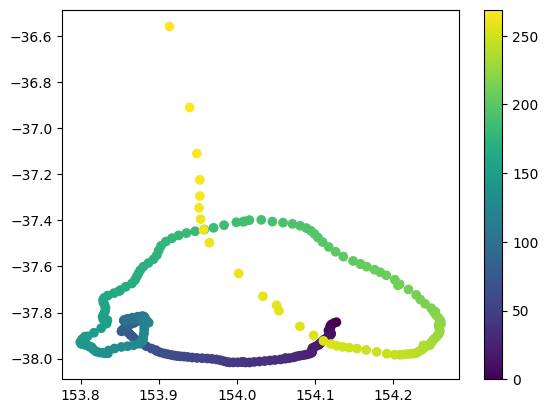

In [166]:
idx1, idx2 = 0, 270
plt.scatter(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'],c=np.arange(len(df_trace.iloc[idx1:idx2])))
plt.colorbar()

# plt.xlim(151, 156)
# plt.ylim( -41, -36)

In [151]:
df_trace

,x0,y0,w,Time
0,152.713003,-37.546783,2.401161,2023-10-23 14:42:00
1,152.690927,-37.546374,2.307934,2023-10-23 15:42:00
2,152.664841,-37.545271,2.223378,2023-10-23 16:42:00
3,152.662863,-37.546846,1.970067,2023-10-23 17:42:00
4,152.663737,-37.547766,1.795091,2023-10-23 18:42:00
...,...,...,...,...
1600,153.121359,-36.119947,0.013303,2023-12-29 06:42:00
1601,153.155058,-36.103806,0.012142,2023-12-29 07:42:00
1602,153.194096,-36.085906,0.010561,2023-12-29 08:42:00
1603,153.246496,-36.074488,0.008968,2023-12-29 09:42:00
